In [8]:
using Pkg; Pkg.activate("../."); Pkg.instantiate()
using Plots; gr()
using SparseArrays
using Statistics
using ModelingToolkit
using LinearAlgebra
using HDF5
using JLD
using Infiltrator
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using DiffEqOperators
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


In [9]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.01
t₁ = 1

D₀ = 1
tolnl = 1e-4
itMax = 100
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1

0.24390243902439027

In [10]:
function loss(T, uD, p)
    
    l_H = 0.0
   
    T = heatflow(T, uD, p)

    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))

    return l_H
end

loss (generic function with 1 method)

In [11]:
function heatflow(T, D, p, tol=Inf)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] #check dimensions
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) #check dimensions
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [12]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

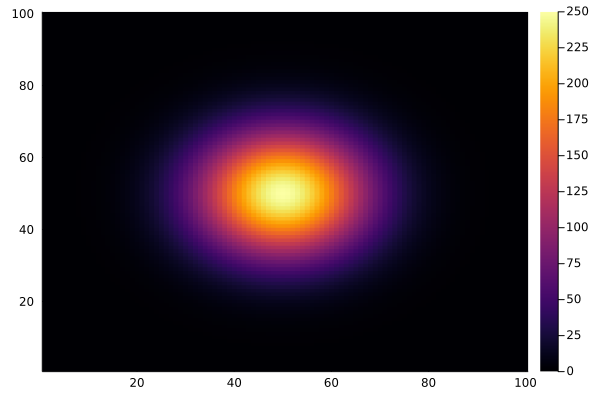

In [13]:
p = (Δx, Δy, Δt, t₁)

T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-1)

heatmap(T₀, clim=(0, maximum(T₀)))

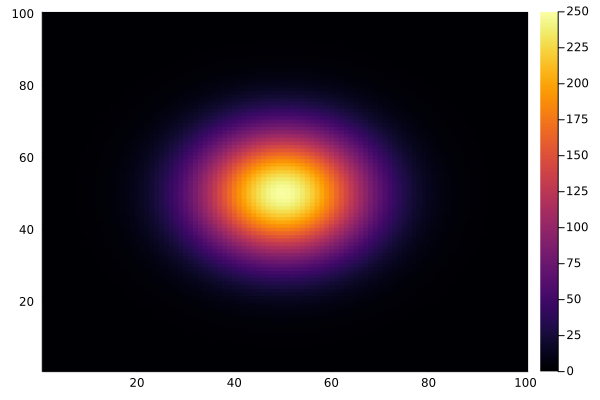

In [14]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [15]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.16311579618178718

In [16]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), 100)

(2.9749888654073713, Zygote.var"#41#42"{typeof(∂(#22))}(∂(#22)))

In [17]:
#all_D = 10 .^ LinRange(-4, 5, 100)
all_D = LinRange(D₀/2, 2D₀, 100)
all_loss = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    println(d)
    println(loss_uD, back_uD(1))
    
    append!(all_loss, loss_uD)
    
end

0.5
0.07979094604952335(-0.16638150528447035,)
0.5151515151515151
0.07732227563096761(-0.16626440503073223,)
0.5303030303030303
0.07485684239885403(-0.16614746884289613,)
0.5454545454545454
0.07239463998834846(-0.1660306963775218,)
0.5606060606060606
0.06993566205130393(-0.16591408729212384,)
0.5757575757575758
0.06747990225621046(-0.1657976412451716,)
0.5909090909090909
0.06502735428811283(-0.16568135789608304,)
0.6060606060606061
0.06257801184858244(-0.165565236905224,)
0.6212121212121212
0.060131868655651996(-0.16544927793390196,)
0.6363636363636364
0.05768891844375638(-0.1653334806443666,)
0.6515151515151515
0.05524915496369331(-0.16521784469980139,)
0.6666666666666666
0.052812571982557045(-0.16510236976432507,)
0.6818181818181819
0.05037916328369812(-0.16498705550298645,)
0.696969696969697
0.047948922666653446(-0.16487190158176096,)
0.7121212121212122
0.04552184394710968(-0.16475690766754678,)
0.7272727272727273
0.0430979209568408(-0.16464207342816436,)
0.7424242424242424
0.040677

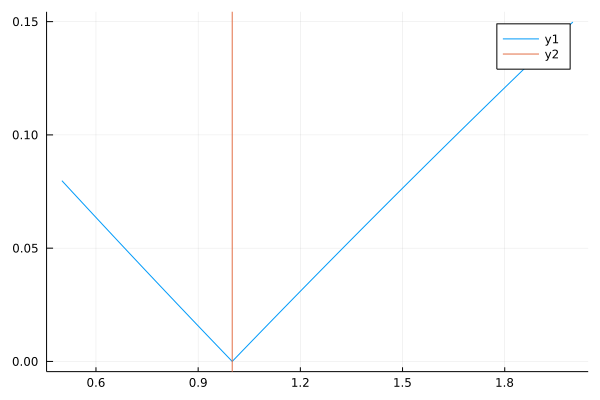

In [18]:
plot(all_D, all_loss)
vline!([D₀])

In [134]:
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

In [161]:
function train(loss, p)
    
    D = 2

    opt = ADAM(0.1)
    @epochs 10 hybrid_train!(loss, D, p, opt)
    
end

function hybrid_train!(loss, D, p, opt)
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), D)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    println(D)
    println(∇_uD)
    
    #D -= 0.01 * ∇_uD
    #println(D)
    Flux.Optimise.update!(opt, D, ∇_uD)
    
end

hybrid_train! (generic function with 2 methods)

In [162]:
train(loss, p)

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


2
0.15553397176457923


LoadError: MethodError: no method matching copyto!(::Int64, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Tuple{}, typeof(+), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(*), Tuple{Float64, Int64}}, Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(*), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(-), Tuple{Int64, Float64}}, Float64}}}})
[0mClosest candidates are:
[0m  copyto!([91m::Union{Base.RefValue{var"#s12"} where var"#s12"<:(GPUArrays.AbstractGPUArray{T, N} where N), Union{GPUArrays.AbstractGPUArray{T, N}, Base.LogicalIndex{T, var"#s5"} where var"#s5"<:GPUArrays.AbstractGPUArray, Base.ReinterpretArray{T, N, var"#s1", var"#s2", IsReshaped} where {var"#s13"<:GPUArrays.AbstractGPUArray, var"#s1", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s13", I, L} where {var"#s3", var"#s4", I, L}, var"#s13"}, IsReshaped}, Base.ReshapedArray{T, N, var"#s4", MI} where {var"#s14"<:GPUArrays.AbstractGPUArray, var"#s4"<:Union{Base.ReinterpretArray{var"#s1", var"#s5", var"#s11", var"#s2", IsReshaped} where {var"#s1", var"#s5", var"#s11", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s14", I, L} where {var"#s3", var"#s4", I, L}, var"#s14"}, IsReshaped}, SubArray{var"#s3", var"#s2", var"#s14", I, L} where {var"#s3", var"#s2", I, L}, var"#s14"}, MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}, N} where N}}, SubArray{T, N, var"#s5", I, L} where {var"#s15"<:GPUArrays.AbstractGPUArray, var"#s5"<:Union{Base.ReinterpretArray{var"#s2", var"#s1", var"#s11", var"#s21", IsReshaped} where {var"#s2", var"#s1", var"#s11", var"#s21"<:Union{SubArray{var"#s3", var"#s4", var"#s15", I, L} where {var"#s3", var"#s4", I, L}, var"#s15"}, IsReshaped}, Base.ReshapedArray{var"#s4", var"#s3", var"#s41", MI} where {var"#s4", var"#s3", var"#s41"<:Union{Base.ReinterpretArray{var"#s1", var"#s5", var"#s11", var"#s2", IsReshaped} where {var"#s1", var"#s5", var"#s11", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s15", I, L} where {var"#s3", var"#s4", I, L}, var"#s15"}, IsReshaped}, SubArray{var"#s3", var"#s2", var"#s15", I, L} where {var"#s3", var"#s2", I, L}, var"#s15"}, MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}, N} where N}}, var"#s15"}, I, L}, Adjoint{T, var"#s1"} where var"#s1"<:GPUArrays.AbstractGPUArray{T, N}, Diagonal{T, var"#s11"} where var"#s11"<:GPUArrays.AbstractGPUArray{T, N}, LowerTriangular{T, var"#s7"} where var"#s7"<:GPUArrays.AbstractGPUArray{T, N}, Transpose{T, var"#s6"} where var"#s6"<:GPUArrays.AbstractGPUArray{T, N}, Tridiagonal{T, var"#s12"} where var"#s12"<:GPUArrays.AbstractGPUArray{T, N}, UnitLowerTriangular{T, var"#s8"} where var"#s8"<:GPUArrays.AbstractGPUArray{T, N}, UnitUpperTriangular{T, var"#s10"} where var"#s10"<:GPUArrays.AbstractGPUArray{T, N}, UpperTriangular{T, var"#s9"} where var"#s9"<:GPUArrays.AbstractGPUArray{T, N}, PermutedDimsArray{T, N, var"#s4", var"#s3", var"#s2"} where {var"#s4", var"#s3", var"#s2"<:GPUArrays.AbstractGPUArray}} where N} where T[39m, ::Base.Broadcast.Broadcasted{var"#s12", Axes, F, Args} where {var"#s12"<:Base.Broadcast.AbstractArrayStyle{0}, Axes, F, Args<:Tuple}) at /Users/facundosapienza/.julia/packages/GPUArrays/Z5nPF/src/host/broadcast.jl:73
[0m  copyto!([91m::SciMLBase.DiffEqArrayOperator[39m, ::Any) at /Users/facundosapienza/.julia/packages/SciMLBase/grNUR/src/operators/basic_operators.jl:113
[0m  copyto!([91m::Zygote.Buffer[39m, ::Any) at /Users/facundosapienza/.julia/packages/Zygote/i1R8y/src/tools/buffer.jl:54
[0m  ...